This book concentrates on methods, technologies, and practice that allow one to make applications fast and able to grow in order to handle more jobs

According to Wikipedia, scalability is "the capability of a system, network or process to handel a growing amount of work, or its potential to be enlarged to accommodate that growth".

Building scalabel applications implies that you distribute the workload across multiple workers using multiple processing units.

- Write a single-threaded application : easy, slow, limited
- Write a multi-threaded application : error-prone, fewer failure scenarios that multi-nodes
- Write network distributed applications : most complicated, no limit

## 1.1 Across CPUs

- Usually done with multithreading
- Threads are contained in a single process. Since they run in parallel, that means they can be executed on separate processosrs even if they are contained in a single process. 

Therefore, when writing a multithreaded application, the code always runs concurently  but runs in parallel only if there is more than one CPU available.

- Should know GIL (global interpreter lock), a lock that must be acquired each time CPython needs to execute byte-code.
- The reason taht the GIL is required in the first place is that it makes sure that some basic Python objects are thread-safe. 

In [1]:
import threading
x = []

def append_two(l):
    l.append(2)
    
threading.Thread(target=append_two, args=(x,)).start

x.append(1)
print(x)

[1]


- list.append is atomic
- This phenomenon happens because only one thread is allowed to execute a bytecode instruction at a time. That also means that if your threads run a lot of bytecodes, there are many contentions to acquire the GIL, and therefore your program cannot be faster than a single-threaded version - or it could even be slower.

The easiest way to know if an operation is thread-safe is to know if it translates to a single bytecode instruction or if it uses a basic type whose operations are atomic."

Multithreading involves several traps, and one of them is that all the pieces of code running concurrrently are sharing the same global environment and variables. Reading or writing global variables should be done exclusive by using techniques such as locking, which complicates your code; morevoer, it is an infinite source of human errors.

## 1.2 Distributed Systems

## 1.3 Service-Oriented Architecture

- SOA refers to network distributed applications

Services built for this kind of architecture should follow afew principles amoung them being stateless. That means services must either modify and return the requested value thile seprarating their functioning from the state of data. This is an essential property, as it makes it easier to scale the services horizontally.

Statelessness is a property that is also shared with the funtional programming paradigm, as discussed in Ch 4 funtional programming.

# Ch2 : CPU scaling

## 2.1 Using Threads

Threads in Python are a good way to urn afunction concurrently other functions. If your system does not support multiple processores, the threads will be executed one after another as scheduled by the operating system. However, if multiple CPUs are available, threads could be scheduled on multiple processing units, once again as determined by the operating system.

By default, there is only one thread - the main thread - and it is the thread that runs your Python application. To start another thread, Python provides the threading module.

In [5]:
import threading

def print_something(something):
    print(something)
    
t = threading.Thread(target=print_something, args=("a"))
t.start()
print("thread started")
t.join()

athread started



Once started, the threads join: the main thread waits for the second thread to complete by calling its join method. Using join is handy in terms of not leaving any threads behind.

If you do not join all your threads and wait for them to finish, it is possible that the main thread finishes and exits before the other threads. If this happens, your program will appear to be blocked and will not respond to even a simple KeyboardInterrupt signal.

To avoid this, and because your program might not be in a position to wait for the threads, you can configure threads as daemons. When a thread is a daemon, it is considered as a background thread by Pyhon and is terminated as soon as the main thread exists.

In [7]:
import threading

def print_something(something):
    print(something)
    
t = threading.Thread(target=print_something, args=('Hello',))

t.daemoin = True
t.start()
print("thread started")

Hellothread started



In [8]:
import random
import threading

results = []

def compute():
    results.append(sum(
        [random.randint(1, 100) for i in range(100000)]))
    
workers = [threading.Thread(target=compute) for x in range(5)]
for worker in workers:
    worker.start()
for worker in workers:
    worker.join()
print("Results: %s" % results)

Results: [5054927, 5047080, 5028958, 5050620, 5048589]


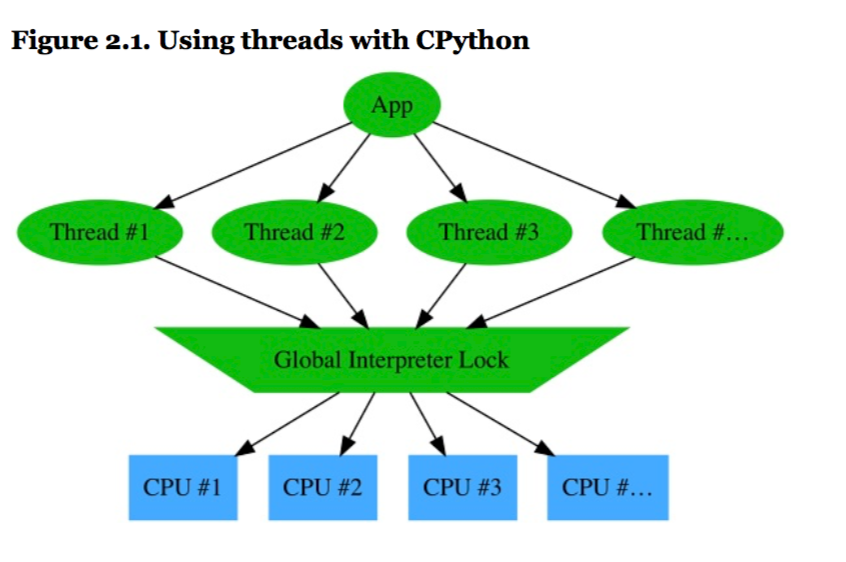

## 2.2 Using Processes

Sindce multithreading is not a perfect scalability solution because of the GIL, using processes instead of dthreads is a good alternative. Python obviously exposes the os.fork system call to create new processes. Howeber, this approach is a little bit too low-level to be interesting in most  cases.

Instead, the multiprocessing package is a good higher-level alternative. It provides an interface that start new processes, whatever your operating system might be.

In [12]:
import random
import multiprocessing

results = []

def compute():
    results.append(sum(
        [random.randint(1, 100) for i in range(100000)]))
    
with multiprocessing.Manager() as manager:
    results = manager.list()
    workers = [multiprocessing.Process(target=compute) \
        for x in range(8)]
    
    for worker in workers:
        worker.start()
    for worker in workers:
        worker.join()
    print("Results: %s" % results)

Results: [5044016, 5054760, 5054912, 5039698, 5058288, 5059891, 5061993, 5053514]


Compared to Example 2.3, "Workers using multithreading", using multiple processes reduces the execution times by 60%. This time, the processes have been able to consume up to 332% of the CU power, which is more than 80% of the computer's CPU capacity, or close to three times more than multithreading.

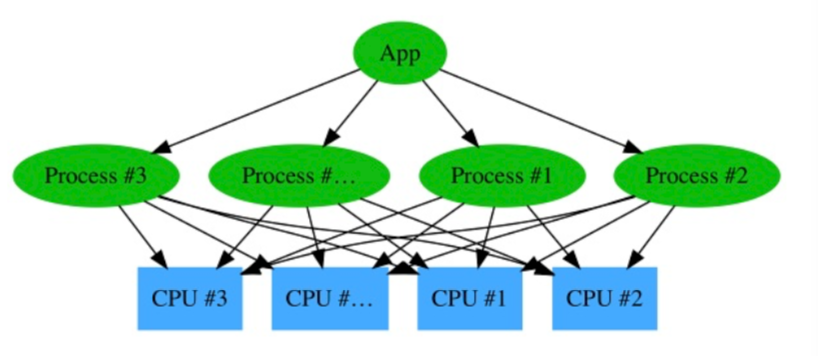

Each time some work can be parallelized for a certain amount of time, it's much better to rely on multiprocessing and to fork jobs, spreading the workload among several CPU cores, rather than using the threading module.

In [13]:
import multiprocessing
import random

def compute(n):
    return sum(
        [random.randint(1, 100) for i in range(100000)])

pool = multiprocessing.Pool(processes=8)
print("Results: %s" % pool.map(compute, range(8)))

Results: [5043536, 5060799, 5065760, 5044195, 5065795, 5059791, 5046397, 5053652]


Using multiprocessing.Pool , there is no need to manage the processes "manually". The pool starts processes on-demand and takes care of reaping them when done. They are also reuable, which avoids calling the fork syscall too often - which is costly.

## 2.3 Using Futures

Python 3.2 introduced the concurrent.futures module, which provides an easy way to schedule asynchronus tasks. The module is also available in Python 2 as it has been back-ported - it can easily be installed it by by running pip install futures.

The concurrent.futures module is pretty straightforward to use. First, one needs to pcik an executor. An executor is responsible for scheduling and running asynchronous tasks. It can be seen as a type of engine for execution. The module currently provides two kinds of executors: concurrent.futures.ThreadPoolExcutor and concurrent.futures.ProcessPoolExecutor.

The process based executor is going to be much more efficient for long-running tasks that benefit from baving an entire CPU available. The threading executor suffers from the same limitation of the threading module, which was covered earlier.

So what is interesting with the concurrent.futures module is that it porvides an easier to use abstraction layer on top of the threading and multiprocessing modules. It allows one to run and parallelize code in a straightforward way, providing an abstract data structure called a concurrent.futures.Future object.

Each time a program schedules some tasks to execute in threads or processes, the concurrent.futures module returns a Future object for each of the task scheduled. This Future object owns the promise of the work to be completed. Once that work is achieved, the result is available in that Future object - so in the end, it does represent the future and the promise of a task to be performed. That is why it is called Future in Python, and sometimes promise in other languages.

In [14]:
from concurrent import futures
import random


def compute():
    return sum(
        [random.randint(1, 100) for i in range(100000)])

with futures.ThreadPoolExecutor(max_workers=8) as executor:
    futs = [executor.submit(compute) for _ in range(8)]
    
results = [f.result() for f in futs]

print("Results: %s" % results)

Results: [5033903, 5062247, 5041010, 5031508, 5047946, 5049850, 5063296, 5049780]


Compared to the threading based example script, you might notice that this one is more functional. I changed the compute function to return the result rather than changing a shared object. It is then easy to manipulate and transfer the Future object and collect the result as desired when it is needed. Functional programming is a perfect paradigm to embrace when trying to spread workload across distributed workers - it is covered more in Ch 4 functional programming.

In [15]:
from concurrent import futures
import random 

def compute():
    return sum(
        [random.randint(1, 100) for i in range(100000)])

with futures.ProcessPoolExecutor() as executor:
    futs = [executor.submit(compute) for _ in range(8)]
    
results = [f.result() for f in futs]

print("Results: %s" % results)

Results: [5034008, 5059114, 5045885, 5052019, 5042994, 5052501, 5047320, 5050172]


## 2.4 Advanced Future Usage

In [1]:
import futurist
from futurist import waiters
import random

def compute():
    return sum(
        [random.randint(1, 100) for i in range(10000)])

with futurist.ThreadPoolExecutor(max_workers=8) as executor:
    futs = [executor.submit(compute) for _ in range(8)]
    print(executor.statistics)
    
results = waiters.wait_for_all(futs)
print(executor.statistics)


print("Results: %s" % [r.result() for r in results.def])

ModuleNotFoundError: No module named 'futurist'

First, futurist allows any application to access statistics about the executor it uses. That view is valuable for tracking the current status of your tasks to report information on how the code runs.

futurist also allows passing a function and possibly denying any new job to be submitted by using the check_and_reject argument. This argument allows controlling the maximum size of the queue in order to avoid any memory overflow.

In [2]:
import futurist 
from futurist import rejection
import random

def compute():
    return sum(
        [random.randint(1, 100) for i in range(10000)])

with futurist.ThreadPoolExecutor(
        max_workers=8,
        check_and_reject=rejection.reject_when_reached) as executor:
    futs= [executor.submit(compute) for _ in range(20)]
    print(executor.statistics)
    
results = [f.result() for f in futs]
print(executor.statistics)

print("Results: %s" % results)

ModuleNotFoundError: No module named 'futurist'

Depending on the speed of your computer, it is likely that Example 2.15, "Using check_and_reject to limit queue size" raises a futurist.RejectedSubmission exception because the executor is not fast enough to absorb the backlog, the size of which is limited to two. This example does not catch the exception - obviously, any decent program should handle that exception and either retry later, or raise a different exception to the caller.

futurist addresses a widespread use case with the futurist.periodics.PeriodicWorker class. It allows scheduling functions to run regularly, based on the system clock.

In [ ]:
import time

from futurist import periodics

@periodics.periodic(1)
def every_one(started_at):
    print("1: %s" % (time.time() - started_at))
    
w = periodics.PeriodicWorker([
    (every_one, (time.time(),), {}),
])

@periodics.periodic(4)
def print_stats():
    print("stats: %s" % list(w.iter_watchers()))
    
w.add(print_stats)
w.start()



## 2.5 Daemon Processes

Being aware of the difference between multithreading and multiprocessing in Python, it becomes more clear that using multiple processes to schedule different jobs is efficient. A widespread use case is to run long-running, background processes that are responsible for scheduling some tasks regularly or processing jobs from a queue.

In [ ]:
import threadin
import time

import cotyledon

class PrinterService(cotyledon.Service):
    name = "printer"
    
    def __init__(self, worker_id):
        super(PrinterService, self).__init__(worker_)